1. We want to predict sentiment of news from companies from Polish Stock Market. We have dataset with labelled news from WIG20 Polish Stock Market index. We will use models for multiclass sentiment classification: Logistic Regression with multiclass classifier, Naive Bayes Classifier, SGD Classifier, Random Forest Classifier and neural networks models sush as Long Short Term Memory (LSTM) network and Convolutional Neural Network (CNN). Moreover we prepare our news using different encoders: simple count cectorizer and tfidf vectorizer, create word embeddings using alghoritms such as skip-gram, CBOW, glove, elmo. We compare every model by encoder used to prepare text. First use simple count vectorizer

In [120]:
#import labelled and preprocessed data
import pandas as pd
news_df=pd.read_csv('/home/slisowski/Portfolio/wig20_sentiment/news_prepared_to_model_wig20.csv', index_col=0)



In [121]:
news_df.dropna(inplace=True)

In [122]:
#From my experience it follows that we should first create set of stop words from news as most frequently occur words
#Now we can count occurencies of words
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
cv=CountVectorizer()
cv.fit(news_df['text'])
freq_terms_neg=cv.transform(news_df[news_df['sentiment']==1].text)
freq_terms_neu=cv.transform(news_df[news_df['sentiment']==2].text)
freq_terms_pos=cv.transform(news_df[news_df['sentiment']==3].text)
neg_arr=np.sum(freq_terms_neg, axis=0)
neu_arr=np.sum(freq_terms_neu, axis=0)
pos_arr=np.sum(freq_terms_pos, axis=0)
neg=np.squeeze(np.asarray(neg_arr))
neu=np.squeeze(np.asarray(neu_arr))
pos=np.squeeze(np.asarray(pos_arr))
terms_freq_df=pd.DataFrame([neg,neu,pos], columns=cv.get_feature_names_out()).transpose()
terms_freq_df=terms_freq_df.rename(columns={0:'negative',1:'neutral',2:'positive'})
terms_freq_df['total']=terms_freq_df['negative']+terms_freq_df['neutral']+terms_freq_df['positive']

In [ ]:
terms_freq_df.sort_values(by='total', ascending=False).iloc[:60]

In [ ]:
stop_words=terms_freq_df.sort_values(by='total', ascending=False).iloc[:15].index.tolist()

In [ ]:
stop_words

In [7]:
#define models and params for GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.model_selection import train_test_split

lr_model=LogisticRegression(multi_class='multinomial', max_iter=5000)
nb_model=MultinomialNB()
svm_model=svm.SVC()



model_params=[('lr',lr_model, {'vect__ngram_range': [(1,1),(1,2),(1,3)],
             'vect__stop_words':[stop_words, 'english', None],
                               
                              'lr__C':[10,1,0.1]}),('nb',nb_model,{'vect__ngram_range': [(1,1),(1,2),(1,3)],
                                                                         'vect__stop_words':[stop_words,'english',None],
                        'nb__alpha':[100,1.0,0.1]})]



svm_params=('svm',svm_model, {'vect__ngram_range': [(1,1),(1,2),(1,3)], 'vect__stop_words':[stop_words,'english',None],'svm__C': [100,1,0.1], 'svm__decision_function_shape': ['ovo'],'svm__kernel': ['linear','rbf', 'poly','sigmoid']})


model_params.append(svm_params)
best_models=[]

X=news_df['text'].tolist()
y=news_df['sentiment'].tolist()
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.3, random_state=42)
vect=CountVectorizer()
for model_desc in model_params:
    
    pipeline=Pipeline([('vect',vect),
                     (str(model_desc[0]), model_desc[1] )])
    print(model_desc[1])
    gscv=GridSearchCV(pipeline, param_grid=model_desc[2], cv=10, scoring='accuracy', verbose=10)
    gscv.fit(X_train, y_train)
    best_models.append((model_desc[0], gscv.best_params_, gscv.best_score_))
    
    


    

LogisticRegression(max_iter=5000, multi_class='multinomial')
Fitting 10 folds for each of 27 candidates, totalling 270 fits
[CV 1/10; 1/27] START lr__C=10, vect__ngram_range=(1, 1), vect__stop_words=['the', 'of', 'in', 'to', 'be', 'and', 'for', 'company', 'on', 'pln', 'say', 'year', 'will', 'by', 'from']


KeyboardInterrupt: 

In [88]:
cv_results_df=pd.DataFrame(best_models, columns=['model', 'best_params','score'])

,model,best_params,score


In [89]:
cv_results_df.set_index('model')

,best_params,score
model,,
lr,"{'lr__C': 1, 'vect__ngram_range': (1, 3), 'vec...",0.708009
nb,"{'nb__alpha': 0.1, 'vect__ngram_range': (1, 3)...",0.689209
svm,"{'svm__C': 100, 'svm__decision_function_shape'...",0.703802


In [ ]:
cv_results_df.to_pickle('/home/slisowski/Portfolio/wig20_sentiment/models/cv_reults.pkl')

In [123]:
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split

In [124]:
news_df.sentiment=news_df.sentiment.map({1:0,2:1,3:2})

In [125]:
X=news_df['text'].tolist()
y=news_df['sentiment'].tolist()
X_train, X_test,y_train,y_test=train_test_split(X,y, test_size = 0.2, random_state = 42)
max_len=128
vect_layer=TextVectorization(output_mode='int', output_sequence_length=max_len, ngrams=(1,2))
vect_layer.adapt(X_train)

In [126]:
n_vocab=len(vect_layer.get_vocabulary())

In [114]:
!pip install -q -U keras-tuner

In [127]:
import keras_tuner as kt

In [177]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience=3, verbose=1,
    mode='auto', min_delta=0.001
)


In [159]:
import keras
import tensorflow as tf
def model_builder_lstm(hp):
    model=keras.Sequential()
    model.add(layers.Input(shape=(1,), dtype=tf.string))
    model.add(vect_layer)
    model.add(layers.Embedding(input_dim=n_vocab, output_dim=max_len))
    hp_dropouts=hp.Float('Dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(layers.SpatialDropout1D(rate=hp_dropouts))
    hp_units=hp.Int('units', min_value=32, max_value=128, step=32)
    model.add(layers.Bidirectional(layers.LSTM(units=hp_units)))
    
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [160]:
tuner=kt.BayesianOptimization(model_builder_lstm,
                    objective='val_accuracy', max_trials=5,
                    directory='bayes_lstm',
                     project_name='bayes_lstm')

In [161]:
tuner.search(X_train, y_train,epochs=10, validation_data=(X_test,y_test), verbose=1, callbacks=[early_stopping_callback])

Trial 5 Complete [00h 03m 08s]
val_accuracy: 0.7076566219329834

Best val_accuracy So Far: 0.7076566219329834
Total elapsed time: 00h 17m 06s
INFO:tensorflow:Oracle triggered exit


In [162]:
best_model_lstm = tuner.get_best_models(num_models=1)[0]


In [163]:
acc_lstm=best_model_lstm.evaluate(X_test, y_test)[1]

41/41 [==============================] - 3s 37ms/step - loss: 0.7041 - accuracy: 0.7077


In [164]:
cv_results_df=pd.read_pickle('/home/slisowski/Portfolio/wig20_sentiment/models/cv_reults.pkl')

In [165]:
cv_results_df['model']

0     lr
1     nb
2    svm
Name: model, dtype: object

In [166]:
params_lstm=tuner.get_best_hyperparameters()[0].values

In [167]:
lstm_data=pd.Series(['lstm', params_lstm, acc_lstm], index=cv_results_df.columns)

In [168]:
lstm_data

model                                                       lstm
best_params    {'Dropout_rate': 0.30000000000000004, 'units':...
score                                                   0.707657
dtype: object

In [169]:
cv_results_df=pd.concat([cv_results_df,lstm_data.to_frame().T], ignore_index=True)

In [170]:
cv_results_df

,model,best_params,score
0,lr,"{'lr__C': 1, 'vect__ngram_range': (1, 3), 'vec...",0.708009
1,nb,"{'nb__alpha': 0.1, 'vect__ngram_range': (1, 3)...",0.689209
2,svm,"{'svm__C': 100, 'svm__decision_function_shape'...",0.703802
3,lstm,"{'Dropout_rate': 0.30000000000000004, 'units':...",0.707657


In [171]:
cv_results_df.to_pickle('/home/slisowski/Portfolio/wig20_sentiment/models/cv_results.pkl')

In [200]:
#Now try to use CNN model
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.models import Model

cnn_inputs=layers.Input(shape=(1,) ,dtype=tf.string)
vect_out=vect_layer(cnn_inputs)
embed_layer=layers.Embedding(input_dim=n_vocab, output_dim=max_len)(vect_out)

conv_1=layers.Conv1D(filters=128, kernel_size=3,padding='same', activation='relu')(embed_layer)
conv_2=layers.Conv1D(filters=128, kernel_size=4,padding='same' ,activation='relu')(embed_layer)
conv_3=layers.Conv1D(filters=128, kernel_size=5,padding='same',activation='relu')(embed_layer)
conv_out = layers.Concatenate(axis=-1)([conv_1, conv_2, conv_3])
pool_layer = layers.MaxPool1D(pool_size=max_len, padding='valid')(conv_out)
flatten_out = layers.Flatten()(pool_layer)
out = layers.Dense(
3, activation='softmax'
#kernel_regularizer=regularizers.l2(0.001)
)(flatten_out)
cnn_model = Model(inputs=cnn_inputs, outputs=out)

cnn_model.compile(
loss='sparse_categorical_crossentropy', 
optimizer='adam', 
metrics=['accuracy'])


cnn_model.summary()

    
                                            
    
    
    


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 128)         0           ['input_11[0][0]']               
 ization)                                                                                         
                                                                                                  
 embedding_10 (Embedding)       (None, 128, 128)     7788288     ['text_vectorization[22][0]']    
                                                                                                  
 conv1d_27 (Conv1D)             (None, 128, 128)     49280       ['embedding_10[0][0]']     

In [201]:

from keras.callbacks import ModelCheckpoint
filepath='cnn_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.tf'
cnn_checkpoint=ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                               save_format='tf',
                             mode='min')

# Train the model
hsitory=cnn_model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    batch_size=128, 
    epochs=10,
    callbacks=[early_stopping_callback, cnn_checkpoint]
)

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 1.0571 - accuracy: 0.4487
Epoch 1: val_loss improved from inf to 0.99347, saving model to cnn_best_model.epoch01-loss0.99.tf


INFO:tensorflow:Assets written to: cnn_best_model.epoch01-loss0.99.tf/assets


INFO:tensorflow:Assets written to: cnn_best_model.epoch01-loss0.99.tf/assets


41/41 [==============================] - 12s 284ms/step - loss: 1.0571 - accuracy: 0.4487 - val_loss: 0.9935 - val_accuracy: 0.5986
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.8006 - accuracy: 0.8153
Epoch 2: val_loss improved from 0.99347 to 0.80276, saving model to cnn_best_model.epoch02-loss0.80.tf


INFO:tensorflow:Assets written to: cnn_best_model.epoch02-loss0.80.tf/assets


INFO:tensorflow:Assets written to: cnn_best_model.epoch02-loss0.80.tf/assets


41/41 [==============================] - 11s 276ms/step - loss: 0.8006 - accuracy: 0.8153 - val_loss: 0.8028 - val_accuracy: 0.6566
Epoch 3/10
41/41 [==============================] - ETA: 0s - loss: 0.4390 - accuracy: 0.9103
Epoch 3: val_loss improved from 0.80276 to 0.67591, saving model to cnn_best_model.epoch03-loss0.68.tf


INFO:tensorflow:Assets written to: cnn_best_model.epoch03-loss0.68.tf/assets


INFO:tensorflow:Assets written to: cnn_best_model.epoch03-loss0.68.tf/assets


41/41 [==============================] - 12s 304ms/step - loss: 0.4390 - accuracy: 0.9103 - val_loss: 0.6759 - val_accuracy: 0.7077
Epoch 4/10
41/41 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9758
Epoch 4: val_loss did not improve from 0.67591
41/41 [==============================] - 10s 254ms/step - loss: 0.1413 - accuracy: 0.9758 - val_loss: 0.7016 - val_accuracy: 0.7022
Epoch 5/10
41/41 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9907
Epoch 5: val_loss did not improve from 0.67591
41/41 [==============================] - 10s 256ms/step - loss: 0.0387 - accuracy: 0.9907 - val_loss: 0.7551 - val_accuracy: 0.6976
Epoch 6/10
41/41 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9934
Epoch 6: val_loss did not improve from 0.67591
41/41 [==============================] - 10s 248ms/step - loss: 0.0206 - accuracy: 0.9934 - val_loss: 0.7969 - val_accuracy: 0.6922
Epoch 6: early stopping


In [ ]:
!pip install plot_keras_history


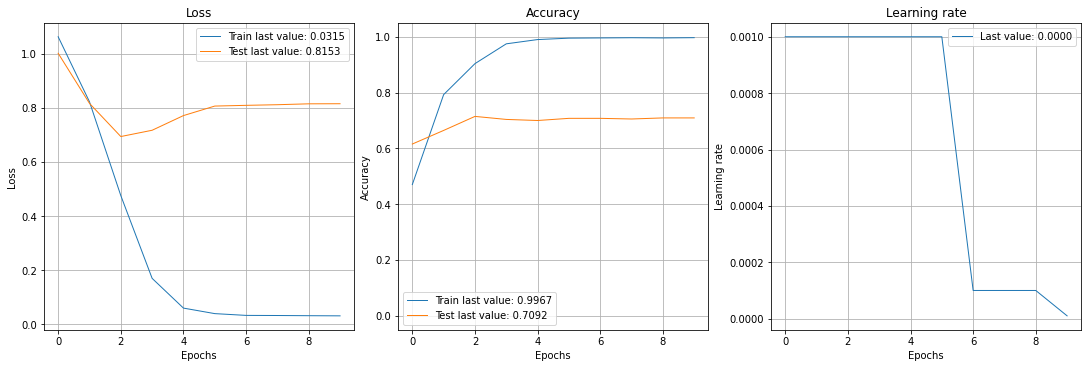

In [86]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(hsitory)
plot_history(hsitory, path="cnn_history.png")
plt.close()

In [ ]:
cv_results_df=pd.read_pickle('/home/slisowski/Portfolio/wig20_sentiment/models/cv_results.pkl')

In [204]:
cnn_model=tf.keras.models.load_model('cnn_best_model.epoch03-loss0.68.tf')

In [205]:
cnn_model.get_config()

{'name': 'model_8',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 1),
    'dtype': 'string',
    'sparse': False,
    'ragged': False,
    'name': 'input_11'},
   'name': 'input_11',
   'inbound_nodes': []},
  {'class_name': 'TextVectorization',
   'config': {'name': 'text_vectorization',
    'trainable': True,
    'batch_input_shape': (None,),
    'dtype': 'string',
    'max_tokens': None,
    'standardize': 'lower_and_strip_punctuation',
    'split': 'whitespace',
    'ngrams': (1, 2),
    'output_mode': 'int',
    'output_sequence_length': 128,
    'pad_to_max_tokens': False,
    'sparse': False,
    'ragged': False,
    'vocabulary': None,
    'idf_weights': None},
   'name': 'text_vectorization',
   'inbound_nodes': [[['input_11', 0, 0, {}]]]},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding_10',
    'trainable': True,
    'batch_input_shape': (None, None),
    'dtype': 'float32',
    'input_dim': 60846,
    'output_dim': 128,
  

In [212]:
cnn_params=cnn_model.get_config()

In [213]:
cnn_score=cnn_model.evaluate(X_test, y_test)[1]

41/41 [==============================] - 1s 14ms/step - loss: 0.6759 - accuracy: 0.7077


In [214]:
cnn_score

0.7076566219329834

In [215]:
cnn_data=pd.Series(['cnn', cnn_params, cnn_score], index=cv_results_df.columns)

In [216]:
cv_results_df=pd.concat([cv_results_df,cnn_data.to_frame().T], ignore_index=True)

In [217]:
cv_results_df

,model,best_params,score
0,lr,"{'lr__C': 1, 'vect__ngram_range': (1, 3), 'vec...",0.708009
1,nb,"{'nb__alpha': 0.1, 'vect__ngram_range': (1, 3)...",0.689209
2,svm,"{'svm__C': 100, 'svm__decision_function_shape'...",0.703802
3,lstm,"{'Dropout_rate': 0.30000000000000004, 'units':...",0.707657
4,cnn,"{'name': 'model_8', 'layers': [{'class_name': ...",0.707657


In [218]:
cv_results_df=pd.read_pickle('/home/slisowski/Portfolio/wig20_sentiment/models/cv_results.pkl')